## 1. Loading packages and data

### 1.a. Loading the packages

In [2]:
!pip install ipywidgets

OUTPUT_DIR = "Output"

import SimpleITK as sitk
import numpy as np

#%matplotlib widget
import gui
import matplotlib.pyplot as plt

# utility method that either downloads data from the Girder repository or
# if already downloaded returns the file name for reading from disk (cached data)
#run update_path_to_download_script
#from downloaddata import fetch_data as fdata
from ipywidgets import interact, fixed

import os
import sys
sys.path.append('../')

from helpers.plot_helper import *
from helpers.augmentation_helper import *

### 1.b. Load data

In [3]:
'''
"""For cached dataset"""

data = [
    sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT1.nrrd")),
    sitk.ReadImage(fdata("vm_head_mri.mha")),
    sitk.ReadImage(fdata("head_mr_oriented.mha")),
]
# Comment out the following line if you want to work in 3D. Note that in 3D some of the notebook visualizations are
# disabled.
data = [data[0][:, 160, :], data[1][:, :, 17], data[2][:, :, 0]]


## Load customized data
# In this section, we consider two datasets: 
# 1. Class's dataset (Set 3)
# 2. Brain Tumor dataset (kaggle)

# load Set 3 data
CLASS_SET_3_PATH = "/home/judy/code/cs6357/CS6357-Fall2024/Set3"
KAGGLE_DATASET_PATH = "/home/judy/code/cs6357/MRI-tumor-brain/Training"

"""For class dataset"""
data_paths = [
    os.path.join(CLASS_SET_3_PATH, "SubjectA_T1.nrrd"),
    os.path.join(CLASS_SET_3_PATH, "SubjectA_T2.nrrd"),
]

# Comment out the following line if you want to work in 3D. Note that in 3D some of the notebook visualizations are
# disabled.
data_set3 = load_images(data_paths)

# data = [data[0][:, 160, :], data[1][:, :, 17]]
disp_images(data_set3, fig_size=(4, 2))

"""For kaggle dataset"""
# For Kaggle dataset
kaggle_data_paths = [
    os.path.join(KAGGLE_DATASET_PATH, "meningioma", "Tr-me_0010.jpg"),
    os.path.join(KAGGLE_DATASET_PATH, "glioma", "Tr-gl_0010.jpg"),
    # sitk.ReadImage(fdata("head_mr_oriented.mha")),
]
kaggle_data = load_images(kaggle_data_paths, sitk.sitkInt8)
disp_images(kaggle_data, fig_size=(4, 2))
'''

def read_images_from_directory(directory_path):
    itk_images = []
    for filename in sorted(os.listdir(directory_path)):  # Sort for consistent ordering
        filepath = os.path.join(directory_path, filename)
        if os.path.isfile(filepath):  # Ensure it's a file
            try:
                itk_image = sitk.ReadImage(filepath)
                itk_images.append(itk_image)
            except Exception as e:
                print(f"Error reading {filepath}: {e}")
    return itk_images

IMAGE_PATH = "datasets/ct_scans/images"
MASK_PATH = "datasets/ct_scans/masks"
data = read_images_from_directory(IMAGE_PATH)
mask_data = read_images_from_directory(MASK_PATH)


## 2. Utility functions

reference_image.GetPixelIDValue(): 13
[0. 0.] [457.54189944 470.65898618]
(5.083798882681564, 4.317972350230415)
center_index: (90, 109)


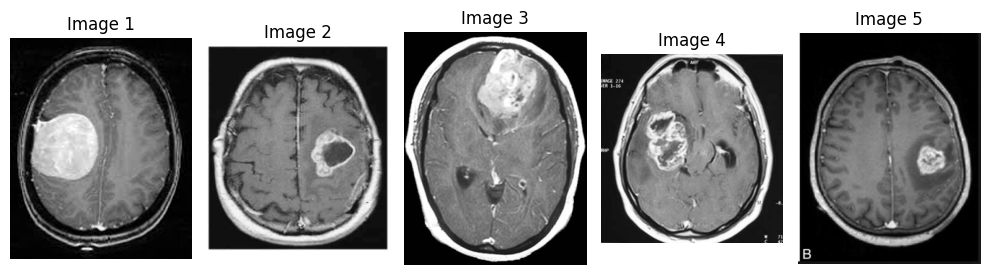

In [4]:
# Create a reference domain. The images will be resampled to this reference domain.

def get_a_reference(data, img_size=128):
    dimension = data[0].GetDimension()
    # Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
    reference_physical_size = np.zeros(dimension)
    for img in data:
        reference_physical_size[:] = [
            (sz - 1) * spc if sz * spc > mx else mx
            for sz, spc, mx in zip(img.GetSize(), img.GetSpacing(), reference_physical_size)
        ]
    
    # Create the reference image with a zero origin, identity direction cosine matrix and dimension
    reference_origin = np.zeros(dimension)
    reference_direction = np.identity(dimension).flatten()

    # Select arbitrary number of pixels per dimension, smallest size that yields desired results
    # or the required size of a pretrained network (e.g. VGG-16 224x224), transfer learning. This will
    # often result in non-isotropic pixel spacing.

    # reference_size = [img_size] * dimension
    
    # keep the original size
    reference_size = [sz for sz in data[0].GetSize()]
    # reference_size = img_size * dimension
    # reference_size = dimension
    reference_spacing = [
        phys_sz / (sz - 1) for sz, phys_sz in zip(reference_size, reference_physical_size)
    ]
    
    reference_image = sitk.Image(reference_size, data[0].GetPixelIDValue())
    print(f"reference_image.GetPixelIDValue(): {reference_image.GetPixelIDValue()}")
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)

    # Always use the TransformContinuousIndexToPhysicalPoint to compute an indexed point's physical coordinates as
    # this takes into account size, spacing and direction cosines. For the vast majority of images the direction
    # cosines are the identity matrix, but when this isn't the case simply multiplying the central index by the
    # spacing will not yield the correct coordinates resulting in a long debugging session.
    reference_center = np.array(
        reference_image.TransformContinuousIndexToPhysicalPoint(
            np.array(reference_image.GetSize()) / 2.0
        )
    )
    return reference_origin, reference_image, reference_center

def display_images(images, titles=None, cmap="gray", fig_size=(10, 10)):
    import matplotlib.pyplot as plt
    import SimpleITK as sitk
    import numpy as np

    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=fig_size)

    # Ensure `axes` is iterable for single images
    if n == 1:
        axes = [axes]

    if titles is None:
        titles = [f"Image {i+1}" for i in range(n)]

    for i, ax in enumerate(axes):
        img = images[i]

        try:
            if img.GetNumberOfComponentsPerPixel() > 1:
                # Multi-channel image: Extract the first channel
                single_channel_image = sitk.VectorIndexSelectionCast(img, 0)
                array = sitk.GetArrayViewFromImage(single_channel_image)
            else:
                # Single-channel image: Directly convert to NumPy
                array = sitk.GetArrayViewFromImage(img)

            # Handle 3D images: Extract a 2D slice if necessary
            if img.GetDimension() == 3:
                slice_index = img.GetSize()[-1] // 2  # Example: middle slice
                array = array[slice_index, :, :]

            ax.imshow(array, cmap=cmap)
            ax.set_title(titles[i])
            ax.axis('off')

        except Exception as e:
            ax.text(0.5, 0.5, f"Error: {e}", ha='center', va='center', color='red')
            ax.axis('off')

    plt.tight_layout()
    plt.show()



# visualizing the reference domain
reference_origin, reference_image, reference_center = get_a_reference(data)
print(reference_origin, reference_center)
print(reference_image.GetSpacing())
center_index = reference_image.TransformPhysicalPointToIndex(reference_center)
print(f"center_index: {center_index}")
reference_image.SetPixel(center_index, [255,255])
# change the center to white color
reference_image.SetPixel(reference_image.TransformPhysicalPointToIndex(reference_center), [1,1])
# plot the reference domain compared with the original image & change the center of the reference domain as white color
#disp_images([data[0], reference_image], fig_size=(4, 2))
display_images(data[:5])


In [5]:
# Once we have a reference domain we can augment the data using 
# any of the SimpleITK global domain transformations. 
# In this notebook we use a similarity transformation 
# (the generate_images function is agnostic to this specific choice).

# Note that you also need to create the labels for your augmented images. 
# If these are just classes then your processing is minimal. 
# If you are dealing with segmentation you will also need to transform the segmentation labels 
# so that they match the transformed image. 
# The following function easily accommodates for this, 
# just provide the labeled image as input and use the sitk.sitkNearestNeighbor interpolator 
# so that you do not introduce labels that were not in the original segmentation.  
def augment_images_spatial(
    original_image,
    reference_image,
    T0,
    T_aug,
    transformation_parameters,
    output_prefix,
    output_suffix,
    interpolator=sitk.sitkLinear,
    default_intensity_value=0.0,
    additional_image_information=None,
):
    """
    Generate the resampled images based on the given transformations.
    Note: Images are written to disk with the useCompression flag
          set to true. This uses the default compression level for the user selected file
          format (via output_suffix).
    Args:
        original_image (SimpleITK image): The image which we will resample and transform.
        reference_image (SimpleITK image): The image onto which we will resample.
        T0 (SimpleITK transform): Transformation which maps points from the reference image coordinate system
            to the original_image coordinate system.
        T_aug (SimpleITK transform): Map points from the reference_image coordinate system back onto itself using the
               given transformation_parameters. The reason we use this transformation as a parameter
               is to allow the user to set its center of rotation to something other than zero.
        transformation_parameters (List of lists): parameter values which we use T_aug.SetParameters().
        output_prefix (string): output file name prefix (file name: output_prefix_p1_p2_..pn_.output_suffix).
        output_suffix (string): output file name suffix (file name: output_prefix_p1_p2_..pn_.output_suffix), also determines
                                the file formt usef for writing to disk.
        interpolator: One of the SimpleITK interpolators.
        default_intensity_value: The value to return if a point is mapped outside the original_image domain.
        additional_image_information: (Iterable([SimpleITK.Image, Interpolator, default_intensity_value])): Apply the same
                                     transformations to this set of images using the given interpolators and intensity values.
                                     The iterable cannot be a zip because that will not allow for repeated iterations.
    """
    all_images = []  # Used only for display purposes in this notebook.
    for current_parameters in transformation_parameters:
        T_aug.SetParameters(current_parameters)
        # Augmentation is done in the reference image space, so we first map the points from the reference image space
        # back onto itself T_aug (e.g. rotate the reference image) and then we map to the original image space T0.
        T_all = sitk.CompositeTransform(T0)
        T_all.AddTransform(T_aug)
        aug_image = sitk.Resample(
            original_image,
            reference_image,
            T_all,
            interpolator,
            default_intensity_value,
        )
        sitk.WriteImage(
            aug_image,
            output_prefix
            + "_"
            + "_".join(str(param) for param in current_parameters)
            + "_."
            + output_suffix,
            useCompression=True,
        )
        # Iterate over all additional images and apply the same transform to them using their specific
        # interpolator and default intensity value (e.g. for a segmentation image sitk.sitkNearestNeighbor and 0)
        if additional_image_information is not None:
            for i, (
                additional_image,
                additional_interpolator,
                additional_default_intensity_value,
            ) in enumerate(additional_image_information):
                additional_aug_image = sitk.Resample(
                    additional_image,
                    reference_image,
                    T_all,
                    additional_interpolator,
                    additional_default_intensity_value,
                )
                sitk.WriteImage(
                    additional_aug_image,
                    output_prefix
                    + "_"
                    + "_".join(str(param) for param in current_parameters)
                    + "_"
                    + f"additional_image_{i}"
                    + "."
                    + output_suffix,
                    useCompression=True,
                )
        all_images.append(aug_image)  # Used only for display purposes in this notebook.
    return all_images  # Used only for display purposes in this notebook.

In [6]:
def point2str(point, precision=1):
    """
    Format a point for printing, based on specified precision with trailing zeros. Uniform printing for vector-like data
    (tuple, numpy array, list).

    Args:
        point (vector-like): nD point with floating point coordinates.
        precision (int): Number of digits after the decimal point.
    Return:
        String represntation of the given point "xx.xxx yy.yyy zz.zzz...".
    """
    return " ".join(f"{c:.{precision}f}" for c in point)


def uniform_random_points(bounds, num_points):
    """
    Generate random (uniform withing bounds) nD point cloud. Dimension is based on the number of pairs in the bounds input.

    Args:
        bounds (list(tuple-like)): list where each tuple defines the coordinate bounds.
        num_points (int): number of points to generate.

    Returns:
        list containing num_points numpy arrays whose coordinates are within the given bounds.
    """
    internal_bounds = [sorted(b) for b in bounds]
    # Generate rows for each of the coordinates according to the given bounds, stack into an array,
    # and split into a list of points.
    mat = np.vstack(
        [np.random.uniform(b[0], b[1], num_points) for b in internal_bounds]
    )
    return list(mat[: len(bounds)].T)


def target_registration_errors(tx, point_list, reference_point_list):
    """
    Distances between points transformed by the given transformation and their
    location in another coordinate system. When the points are only used to evaluate
    registration accuracy (not used in the registration) this is the target registration
    error (TRE).
    """
    return [
        np.linalg.norm(np.array(tx.TransformPoint(p)) - np.array(p_ref))
        for p, p_ref in zip(point_list, reference_point_list)
    ]


def print_transformation_differences(tx1, tx2):
    """
    Check whether two transformations are "equivalent" in an arbitrary spatial region
    either 3D or 2D, [x=(-10,10), y=(-100,100), z=(-1000,1000)]. This is just a sanity check,
    as we are just looking at the effect of the transformations on a random set of points in
    the region.
    """
    if tx1.GetDimension() == 2 and tx2.GetDimension() == 2:
        bounds = [(-10, 10), (-100, 100)]
    elif tx1.GetDimension() == 3 and tx2.GetDimension() == 3:
        bounds = [(-10, 10), (-100, 100), (-1000, 1000)]
    else:
        raise ValueError(
            "Transformation dimensions mismatch, or unsupported transformation dimensionality"
        )
    num_points = 10
    point_list = uniform_random_points(bounds, num_points)
    tx1_point_list = [tx1.TransformPoint(p) for p in point_list]
    differences = target_registration_errors(tx2, point_list, tx1_point_list)
    print(
        tx1.GetName()
        + "-"
        + tx2.GetName()
        + f":\tminDifference: {min(differences):.2f} maxDifference: {max(differences):.2f}"
    )
    

def resample(image, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = image
    interpolator = sitk.sitkCosineWindowedSinc
    default_value = 100.0
    return sitk.Resample(image, reference_image, transform, interpolator, default_value)

def parameter_space_regular_grid_sampling(*transformation_parameters):
    """
    Create a list representing a regular sampling of the parameter space.
    
    Args:
        *transformation_paramters: Two or more numpy ndarrays representing parameter values. 
                                   The order of the arrays should match the ordering of the 
                                   SimpleITK transformation parametrization (e.g., Similarity2DTransform: scaling, rotation, tx, ty).
    
    Return:
        List of lists representing the regular grid sampling.
    """
    if len(transformation_parameters) == 1:
        # Handle the case where only one parameter is provided (e.g., scaling)
        return [[p.item()] for p in transformation_parameters[0]]
    else:
        # Use meshgrid when more than one parameter is provided
        return [
            [p.item() for p in parameter_values]
            for parameter_values in np.nditer(np.meshgrid(*transformation_parameters))
        ]



def similarity3D_parameter_space_regular_sampling(
    thetaX, thetaY, thetaZ, tx, ty, tz, scale
):
    """
    Create a list representing a regular sampling of the 3D similarity transformation parameter space. As the
    SimpleITK rotation parametrization uses the vector portion of a versor we don't have an
    intuitive way of specifying rotations. We therefor use the ZYX Euler angle parametrization and convert to
    versor.
    Args:
        thetaX, thetaY, thetaZ: numpy ndarrays with the Euler angle values to use, in radians.
        tx, ty, tz: numpy ndarrays with the translation values to use in mm.
        scale: numpy array with the scale values to use.
    Return:
        List of lists representing the parameter space sampling (vx,vy,vz,tx,ty,tz,s).
    """
    return [
        list(eul2quat(parameter_values[0], parameter_values[1], parameter_values[2]))
        + [p.item() for p in parameter_values[3:]]
        for parameter_values in np.nditer(
            np.meshgrid(thetaX, thetaY, thetaZ, tx, ty, tz, scale)
        )
    ]


def similarity3D_parameter_space_random_sampling(
    thetaX, thetaY, thetaZ, tx, ty, tz, scale, n
):
    """
    Create a list representing a random (uniform) sampling of the 3D similarity transformation parameter space. As the
    SimpleITK rotation parametrization uses the vector portion of a versor we don't have an
    intuitive way of specifying rotations. We therefor use the ZYX Euler angle parametrization and convert to
    versor.
    Args:
        thetaX, thetaY, thetaZ: Ranges of Euler angle values to use, in radians.
        tx, ty, tz: Ranges of translation values to use in mm.
        scale: Range of scale values to use.
        n: Number of samples.
    Return:
        List of lists representing the parameter space sampling (vx,vy,vz,tx,ty,tz,s).
    """
    theta_x_vals = (thetaX[1] - thetaX[0]) * np.random.random(n) + thetaX[0]
    theta_y_vals = (thetaY[1] - thetaY[0]) * np.random.random(n) + thetaY[0]
    theta_z_vals = (thetaZ[1] - thetaZ[0]) * np.random.random(n) + thetaZ[0]
    tx_vals = (tx[1] - tx[0]) * np.random.random(n) + tx[0]
    ty_vals = (ty[1] - ty[0]) * np.random.random(n) + ty[0]
    tz_vals = (tz[1] - tz[0]) * np.random.random(n) + tz[0]
    s_vals = (scale[1] - scale[0]) * np.random.random(n) + scale[0]
    res = list(
        zip(theta_x_vals, theta_y_vals, theta_z_vals, tx_vals, ty_vals, tz_vals, s_vals)
    )
    return [list(eul2quat(*(p[0:3]))) + list(p[3:7]) for p in res]


def eul2quat(ax, ay, az, atol=1e-8):
    """
    Translate between Euler angle (ZYX) order and quaternion representation of a rotation.
    Args:
        ax: X rotation angle in radians.
        ay: Y rotation angle in radians.
        az: Z rotation angle in radians.
        atol: tolerance used for stable quaternion computation (qs==0 within this tolerance).
    Return:
        Numpy array with three entries representing the vectoral component of the quaternion.

    """
    # Create rotation matrix using ZYX Euler angles and then compute quaternion using entries.
    cx = np.cos(ax)
    cy = np.cos(ay)
    cz = np.cos(az)
    sx = np.sin(ax)
    sy = np.sin(ay)
    sz = np.sin(az)
    r = np.zeros((3, 3))
    r[0, 0] = cz * cy
    r[0, 1] = cz * sy * sx - sz * cx
    r[0, 2] = cz * sy * cx + sz * sx

    r[1, 0] = sz * cy
    r[1, 1] = sz * sy * sx + cz * cx
    r[1, 2] = sz * sy * cx - cz * sx

    r[2, 0] = -sy
    r[2, 1] = cy * sx
    r[2, 2] = cy * cx

    # Compute quaternion:
    qs = 0.5 * np.sqrt(r[0, 0] + r[1, 1] + r[2, 2] + 1)
    qv = np.zeros(3)
    # If the scalar component of the quaternion is close to zero, we
    # compute the vector part using a numerically stable approach
    if np.isclose(qs, 0.0, atol):
        i = np.argmax([r[0, 0], r[1, 1], r[2, 2]])
        j = (i + 1) % 3
        k = (j + 1) % 3
        w = np.sqrt(r[i, i] - r[j, j] - r[k, k] + 1)
        qv[i] = 0.5 * w
        qv[j] = (r[i, j] + r[j, i]) / (2 * w)
        qv[k] = (r[i, k] + r[k, i]) / (2 * w)
    else:
        denom = 4 * qs
        qv[0] = (r[2, 1] - r[1, 2]) / denom
        qv[1] = (r[0, 2] - r[2, 0]) / denom
        qv[2] = (r[1, 0] - r[0, 1]) / denom
    return qv

## 3. Affine Transformation

**First, I will levergae affine transform from ITK**
The affine transform is capable of representing translations, rotations, shearing, and scaling.

All global transformations **except translation** are of the form:
$$T(\mathbf{x}) = A(\mathbf{x}-\mathbf{c}) + \mathbf{t} + \mathbf{c}$$

   Nomenclature (when printing your transformation):

   * Matrix: the matrix $A$
   * Center: the point $\mathbf{c}$
   * Translation: the vector $\mathbf{t}$
   * Offset: $\mathbf{t} + \mathbf{c} - A\mathbf{c}$

### Single transformation

reference_image.GetPixelIDValue(): 13


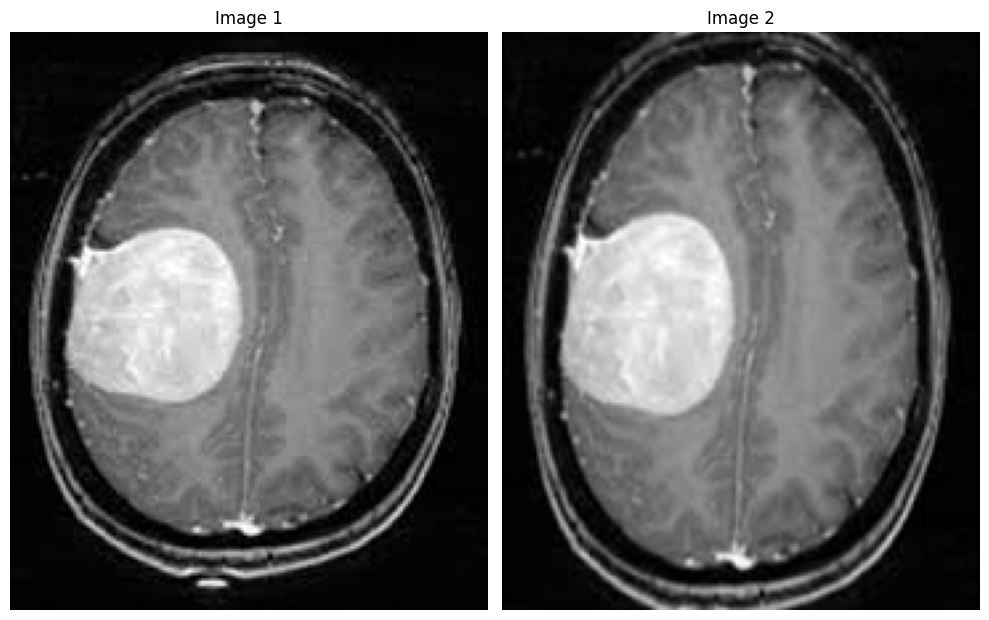

In [7]:
# Scaling function
def single_transform(original_image, reference_origin, reference_image, reference_center, aug_transform):
    # Transform which maps from the reference_image to the current img with the translation mapping the image
    # origins to each other.
    dimension = original_image.GetDimension()
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(original_image.GetDirection())
    transform.SetTranslation(np.array(original_image.GetOrigin()) - reference_origin)
    
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(
        original_image.TransformContinuousIndexToPhysicalPoint(np.array(original_image.GetSize()) / 2.0)
    )
    
    centering_transform.SetOffset(
        np.array(transform.GetInverse().TransformPoint(img_center) - reference_center)
    )
    
    centered_transform = sitk.CompositeTransform(transform)
    centered_transform.AddTransform(centering_transform)
    
    centered_transform.AddTransform(aug_transform)
    # Resample the image
    aug_image = sitk.Resample(original_image, reference_image, centered_transform, sitk.sitkLinear, 0.0)
    return aug_image

def single_transform_img(img, mode="scale", params=[1.5, 1.5]):
    dimension = img[0].GetDimension()
    reference_origin, reference_image, reference_center = get_a_reference(img, img_size=img[0].GetSize())
    #display_images([img[0], reference_image])
    aug_transform = []
    # rigid_euler <- Euler3DTransform(rigid_center, theta_x, theta_y, theta_z, rigid_translation)
    
    switcher = {
        "scale": sitk.ScaleTransform(dimension, params),
        "translate": sitk.TranslationTransform(dimension, params),
        "rotate": sitk.Euler2DTransform() if dimension == 2 else sitk.Euler3DTransform(),
        # "shearing": sitk.Shear2DTransform() if dimension == 2 else sitk.Shear3DTransform(),
    }
    
    aug_transform = switcher.get(mode)
    if mode == 'scale':
        aug_transform.SetCenter(reference_center)
    if mode == "rotation":
        if dimension == 2:
            aug_transform.SetAngle(params[-1])
        else:
            aug_transform.SetRotation(*params[0:3])
    T0 = reference_image
    aug_image = single_transform(img[0], reference_origin, reference_image, reference_center, aug_transform)
    return aug_image  


aug_image = single_transform_img(data, mode="scale", params=[0.2, 0.2])

#disp_images([kaggle_data[0], aug_image], fig_size=(6, 4))  
display_images([data[0], aug_image])

### Other examples

reference_image.GetPixelIDValue(): 13


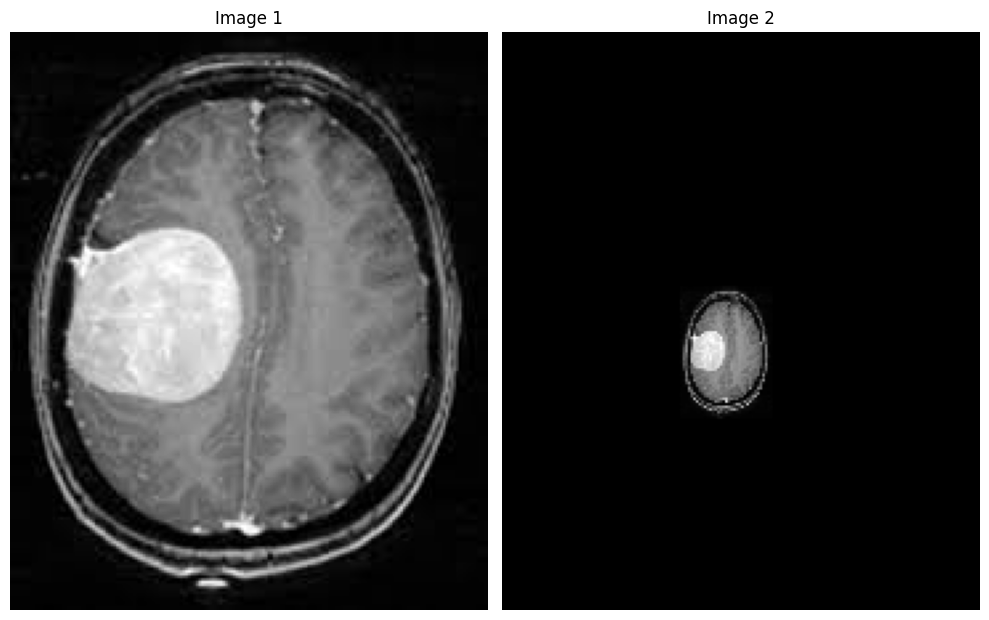

In [8]:
# Translation

aug_image = single_transform_img(data, mode="translate", params=[30, -50, 0])
#disp_images([kaggle_data[0], aug_image], fig_size=(6, 4))
display_images([data[0], aug_image])

reference_image.GetPixelIDValue(): 13


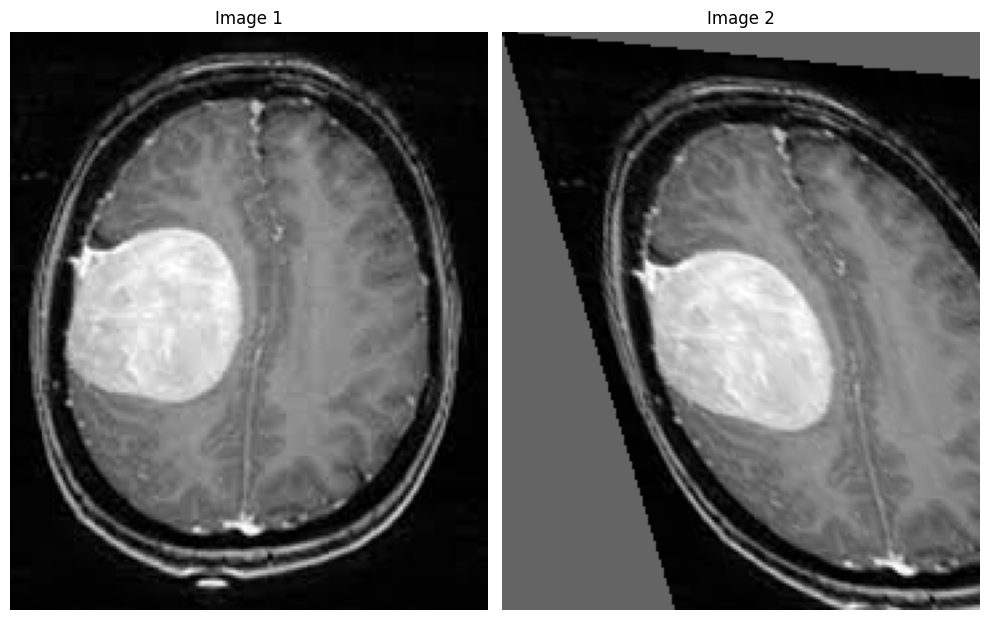

In [9]:
def affine_shear(img, transform, dimension, x_shear=0.3, y_shear=0.1):
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension, dimension))
    matrix[0, 1] = -x_shear
    matrix[1, 0] = -y_shear
    new_transform.SetMatrix(matrix.ravel())
    resampled = resample(img, new_transform)
    # myshow(resampled, "Sheared")
    # print(matrix)
    return resampled

dimension = 2
original_image = data[0]
reference_origin, reference_image, reference_center = get_a_reference(data, img_size=128)

transform = sitk.AffineTransform(dimension)
transform.SetMatrix(original_image.GetDirection())
transform.SetTranslation(np.array(original_image.GetOrigin()) - reference_origin)

# Modify the transformation to align the centers of the original and reference image instead of their origins.
centering_transform = sitk.TranslationTransform(dimension)
img_center = np.array(
    original_image.TransformContinuousIndexToPhysicalPoint(np.array(original_image.GetSize()) / 2.0)
)

centering_transform.SetOffset(
    np.array(transform.GetInverse().TransformPoint(img_center) - reference_center)
)

centered_transform = sitk.CompositeTransform(transform)
centered_transform.AddTransform(centering_transform)
sheared = affine_shear(data[0], transform, 2, x_shear=0.3, y_shear=0.1)
#disp_images([kaggle_data[0], sheared], fig_size=(6, 4))
display_images([data[0], sheared])

### Combined transformations

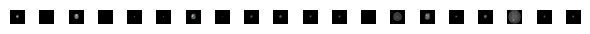

In [10]:
#data = kaggle_data
dimension = data[0].GetDimension()

# Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
reference_physical_size = np.zeros(dimension)
for img in data:
    reference_physical_size[:] = [
        (sz - 1) * spc if sz * spc > mx else mx
        for sz, spc, mx in zip(img.GetSize(), img.GetSpacing(), reference_physical_size)
    ]

# Create the reference image with a zero origin, identity direction cosine matrix and dimension
reference_origin = np.zeros(dimension)
reference_direction = np.identity(dimension).flatten()

# Select arbitrary number of pixels per dimension, smallest size that yields desired results
# or the required size of a pretrained network (e.g. VGG-16 224x224), transfer learning. This will
# often result in non-isotropic pixel spacing.
reference_size = [128] * dimension
reference_spacing = [
    phys_sz / (sz - 1) for sz, phys_sz in zip(reference_size, reference_physical_size)
]

# Another possibility is that you want isotropic pixels, then you can specify the image size for one of
# the axes and the others are determined by this choice. Below we choose to set the x axis to 128 and the
# spacing set accordingly.
# Uncomment the following lines to use this strategy.
# reference_size_x = 128
# reference_spacing = [reference_physical_size[0]/(reference_size_x-1)]*dimension
# reference_size = [int(phys_sz/(spc) + 1) for phys_sz,spc in zip(reference_physical_size, reference_spacing)]

reference_image = sitk.Image(reference_size, data[0].GetPixelIDValue())
reference_image.SetOrigin(reference_origin)
reference_image.SetSpacing(reference_spacing)
reference_image.SetDirection(reference_direction)

# Always use the TransformContinuousIndexToPhysicalPoint to compute an indexed point's physical coordinates as
# this takes into account size, spacing and direction cosines. For the vast majority of images the direction
# cosines are the identity matrix, but when this isn't the case simply multiplying the central index by the
# spacing will not yield the correct coordinates resulting in a long debugging session.
reference_center = np.array(
    reference_image.TransformContinuousIndexToPhysicalPoint(
        np.array(reference_image.GetSize()) / 2.0
    )
)

dimension = data[0].GetDimension()
aug_transform = (
    sitk.Similarity2DTransform() if dimension == 2 else sitk.Similarity3DTransform()
)

all_images = []
OUTPUT_DIR = "datasets/ct_scans/transformed/images"
# remove old files
import shutil
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)

os.makedirs(OUTPUT_DIR, exist_ok=True)

for index, img in enumerate(data):
    # Transform which maps from the reference_image to the current img with the translation mapping the image
    # origins to each other.
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(
        img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize()) / 2.0)
    )
    centering_transform.SetOffset(
        np.array(transform.GetInverse().TransformPoint(img_center) - reference_center)
    )
    centered_transform = sitk.CompositeTransform(transform)
    centered_transform.AddTransform(centering_transform)

    # Set the augmenting transform's center so that rotation is around the image center.
    aug_transform.SetCenter(reference_center)

    if dimension == 2:
        # The parameters are scale (+-10%), rotation angle (+-10 degrees), x translation, y translation
        transformation_parameters_list = parameter_space_regular_grid_sampling(
            np.linspace(0.5, 1.5, 3), # → scale
            np.linspace(-np.pi / 3.0, np.pi / 3.0, 3), # → rotation
            np.linspace(-10, 20, 3), # → x translation
            np.linspace(-10, 20, 3), # → y translation
        )
    else:
        transformation_parameters_list = similarity3D_parameter_space_random_sampling(
            thetaX=(-np.pi / 18.0, np.pi / 18.0),
            thetaY=(-np.pi / 18.0, np.pi / 18.0),
            thetaZ=(-np.pi / 18.0, np.pi / 18.0),
            tx=(-10.0, 10.0),
            ty=(-10.0, 10.0),
            tz=(-10.0, 10.0),
            scale=(0.9, 1.1),
            n=10,
        )
    #         transformation_parameters_list = similarity3D_parameter_space_regular_sampling(np.linspace(-np.pi/18.0,np.pi/18.0,3),
    #                                                                                        np.linspace(-np.pi/18.0,np.pi/18.0,3),
    #                                                                                        np.linspace(-np.pi/18.0,np.pi/18.0,3),
    #                                                                                        np.linspace(-10,10,3),
    #                                                                                        np.linspace(-10,10,3),
    #                                                                                        np.linspace(-10,10,3),
    #                                                                                        np.linspace(0.9,1.1,3))
    additional_image_information = None
    reference_segmentations = None
    if reference_segmentations:
        all_additional_image_information = list(
            zip(
                reference_segmentations,
                [sitk.sitkNearestNeighbor] * len(reference_segmentations),
                [0] * len(reference_segmentations),
            )
        )
    generated_images = augment_images_spatial(
        img,
        reference_image,
        centered_transform,
        aug_transform,
        transformation_parameters_list,
        OUTPUT_DIR,
        "jpg",
        additional_image_information=None,
    )

    if (
        dimension == 2
    ):  # in 2D we join all of the images into a 3D volume which we use for display.
        all_images.append(sitk.JoinSeries(generated_images))
# If working in 2D, display the resulting set of images.
if dimension == 2:
    gui.MultiImageDisplay(image_list=all_images, shared_slider=True, figure_size=(6, 2))

## Method #02:  Radial Distortion

Some 2D medical imaging modalities, such as endoscopic video and X-ray images acquired with C-arms using image intensifiers, exhibit radial distortion. The common model for such distortion was described by Brown ["Close-range camera calibration", Photogrammetric Engineering, 37(8):855–866, 1971]:
$$
\mathbf{p}_u = \mathbf{p}_d + (\mathbf{p}_d-\mathbf{p}_c)(k_1r^2 + k_2r^4 + k_3r^6 + \ldots)
$$

where:
* $\mathbf{p}_u$ is a point in the undistorted image
* $\mathbf{p}_d$ is a point in the distorted image
* $\mathbf{p}_c$ is the center of distortion
* $r = \|\mathbf{p}_d-\mathbf{p}_c\|$
* $k_i$ are coefficients of the radial distortion

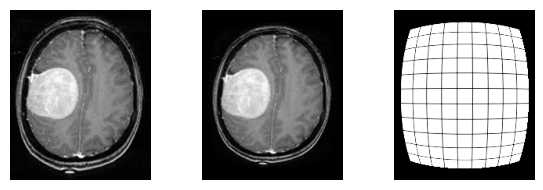

In [11]:
def radial_distort(image, k1, k2, k3, distortion_center=None):
    c = distortion_center
    if not c:  # The default distortion center coincides with the image center
        c = np.array(
            image.TransformContinuousIndexToPhysicalPoint(
                np.array(image.GetSize()) / 2.0
            )
        )

    # Compute the vector image (p_d - p_c)
    delta_image = sitk.PhysicalPointSource(
        sitk.sitkVectorFloat64,
        image.GetSize(),
        image.GetOrigin(),
        image.GetSpacing(),
        image.GetDirection(),
    )
    delta_image_list = [
        sitk.VectorIndexSelectionCast(delta_image, i) - c[i] for i in range(len(c))
    ]

    # Compute the radial distortion expression
    r2_image = sitk.NaryAdd([img**2 for img in delta_image_list])
    r4_image = r2_image**2
    r6_image = r2_image * r4_image
    disp_image = k1 * r2_image + k2 * r4_image + k3 * r6_image
    displacement_image = sitk.Compose([disp_image * img for img in delta_image_list])

    displacement_field_transform = sitk.DisplacementFieldTransform(displacement_image)
    return sitk.Resample(image, image, displacement_field_transform)


k1 = 0.00001
k2 = 0.0000000000001
k3 = 0.0000000000001


original_image = data[0]
distorted_image = radial_distort(original_image, k1, k2, k3)
# Use a grid image to highlight the distortion.
grid_image = sitk.GridSource(
    outputPixelType=sitk.sitkUInt16,
    size=original_image.GetSize(),
    sigma=[0.1] * dimension,
    gridSpacing=[20.0] * dimension,
)
grid_image.CopyInformation(original_image)
distorted_grid = radial_distort(grid_image, k1, k2, k3)
disp_images([original_image, distorted_image, distorted_grid], fig_size=(6, 2))


In [ ]:
import numpy as np
import SimpleITK as sitk

def radial_distort_numpy(image, image2, k1, k2, k3, distortion_center=None):
    """
    Apply radial distortion to an image and return the result as a NumPy array.
    Handles both SimpleITK.Image and NumPy array inputs.
    """
    if isinstance(image, sitk.Image):
        # Compute distortion center for SimpleITK.Image
        if distortion_center is None:
            distortion_center = np.array(
                image.TransformContinuousIndexToPhysicalPoint(
                    np.array(image.GetSize()) / 2.0
                )
            )
        itk_image = image
    elif isinstance(image, np.ndarray):
        # Convert NumPy array to SimpleITK.Image
        itk_image = sitk.GetImageFromArray(image)
        # Compute distortion center for NumPy array
        if distortion_center is None:
            distortion_center = np.array(image.shape[::-1]) / 2.0  # Reverse order: (W, H, D)
    else:
        raise TypeError("Input must be a SimpleITK.Image or NumPy array.")

    # Compute the vector image (p_d - p_c)
    delta_image = sitk.PhysicalPointSource(
        sitk.sitkVectorFloat64,
        itk_image.GetSize(),
        itk_image.GetOrigin(),
        itk_image.GetSpacing(),
        itk_image.GetDirection(),
    )
    delta_image_list = [
        sitk.VectorIndexSelectionCast(delta_image, i) - distortion_center[i]
        for i in range(len(distortion_center))
    ]

    # Compute the radial distortion expression
    r2_image = sitk.NaryAdd([img**2 for img in delta_image_list])
    r4_image = r2_image**2
    r6_image = r2_image * r4_image
    disp_image = k1 * r2_image + k2 * r4_image + k3 * r6_image
    displacement_image = sitk.Compose([disp_image * img for img in delta_image_list])

    displacement_field_transform = sitk.DisplacementFieldTransform(displacement_image)
    distorted_image = sitk.Resample(itk_image, itk_image, displacement_field_transform)

    # Convert the distorted image back to NumPy array
    distorted_array = sitk.GetArrayFromImage(distorted_image)
    return distorted_array


In [51]:
def resample_image(image, reference_image):
    """
    Resample 'image' to match the properties of 'reference_image'.
    """
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference_image)
    resampler.SetInterpolator(sitk.sitkLinear)  # Choose appropriate interpolator
    return resampler.Execute(image)


In [58]:
import numpy as np
import SimpleITK as sitk

def radial_distort_numpy_pair(image1, image2, k1, k2, k3, distortion_center=None):
    """
    Apply radial distortion to a pair of images with different channel sizes.
    Handles both SimpleITK.Image and NumPy array inputs.
    """
    def prepare_image(image):
        if isinstance(image, sitk.Image):
            return image
        elif isinstance(image, np.ndarray):
            return sitk.GetImageFromArray(image)
        else:
            raise TypeError("Input must be a SimpleITK.Image or NumPy array.")

    # Convert images to SimpleITK if necessary
    itk_image1 = prepare_image(image1)
    itk_image2 = prepare_image(image2)

    # Ensure both images are single-channel for processing
    def make_single_channel(itk_image):
        if itk_image.GetNumberOfComponentsPerPixel() > 1:  # Multi-channel (e.g., RGB)
            # Extract channels and compute their mean
            channels = [sitk.VectorIndexSelectionCast(itk_image, i) for i in range(itk_image.GetNumberOfComponentsPerPixel())]
            mean_image = sum(channels) / len(channels)
            return mean_image
        return itk_image

    itk_image1 = make_single_channel(itk_image1)
    itk_image2 = make_single_channel(itk_image2)

    # Resample image2 to match image1 if necessary
    if itk_image1.GetSize() != itk_image2.GetSize():
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(itk_image1)
        itk_image2 = resampler.Execute(itk_image2)

    # Compute the distortion center (shared for both images)
    if distortion_center is None:
        distortion_center = np.array(
            itk_image1.TransformContinuousIndexToPhysicalPoint(
                np.array(itk_image1.GetSize()) / 2.0
            )
        )

    # Compute the vector image (p_d - p_c)
    delta_image = sitk.PhysicalPointSource(
        sitk.sitkVectorFloat64,
        itk_image1.GetSize(),
        itk_image1.GetOrigin(),
        itk_image1.GetSpacing(),
        itk_image1.GetDirection(),
    )
    delta_image_list = [
        sitk.VectorIndexSelectionCast(delta_image, i) - distortion_center[i]
        for i in range(2)  # Use only 2 dimensions for 2D images
    ]

    # Compute the radial distortion expression
    r2_image = sitk.NaryAdd([img**2 for img in delta_image_list])
    r4_image = r2_image**2
    r6_image = r2_image * r4_image
    disp_image = k1 * r2_image + k2 * r4_image + k3 * r6_image
    displacement_image = sitk.Compose([disp_image * img for img in delta_image_list])

    # Apply the displacement field to both images
    displacement_field_transform = sitk.DisplacementFieldTransform(displacement_image)
    distorted_image1 = sitk.Resample(itk_image1, itk_image1, displacement_field_transform)
    distorted_image2 = sitk.Resample(itk_image2, itk_image2, displacement_field_transform)

    # Convert the distorted images back to NumPy arrays
    distorted_array1 = sitk.GetArrayFromImage(distorted_image1)
    distorted_array2 = sitk.GetArrayFromImage(distorted_image2)

    return distorted_array1, distorted_array2


In [ ]:
image_paths = "datasets/ct_scans/images"
image_paths = sorted(os.listdir(image_paths))
mask_paths = "datasets/ct_scans/masks"
mask_paths = sorted(os.listdir(mask_paths))

for idx, img_path in enumerate(image_paths):
    img_path = os.path.join("datasets/ct_scans/images", img_path)
    mask_path = os.path.join("datasets/ct_scans/masks", mask_paths[idx])
    original_image = sitk.ReadImage(img_path)
    mask_img = sitk.ReadImage(mask_path)
    
    # distorted_image, distorted_mask = radial_distort_numpy_pair(original_image[0], mask_img, k1, k2, k3)
    distorted_image = radial_distort_numpy(original_image, k1, k2, k3)
    distorted_mask = radial_distort_numpy(mask_img, k1, k2, k3)
    distorted_mask = np.transpose(distorted_mask, (1, 2, 0))
    obj_identifier = img_path.split(".")[-2].split("/")[-1]

    # Normalize and convert for saving
    distorted_image_normalized = (distorted_image - distorted_image.min()) / (distorted_image.max() - distorted_image.min())
    distorted_image_uint8 = (distorted_image_normalized * 255).astype(np.uint8)

    distorted_mask_normalized = (distorted_mask - distorted_mask.min()) / (distorted_mask.max() - distorted_mask.min())
    distorted_mask_uint8 = (distorted_mask_normalized * 255).astype(np.uint8)

    # Save as PNG images
    print("Shapes of the images:", distorted_image_uint8.shape, distorted_mask_uint8.shape)
    cv2.imwrite(f"datasets/ct_scans/transformed/images/distorted_{obj_identifier}.png", distorted_image_uint8)
    cv2.imwrite(f"datasets/ct_scans/transformed/masks/distorted_{obj_identifier}.png", distorted_mask_uint8)


IndexError: invalid slice extraction to 1 dimension

## Method #03: Intensity modifications


SimpleITK has many filters that are potentially relevant for data augmentation via modification of intensities. For example:
* Image smoothing, always read the documentation carefully, similar filters use use different parametrization $\sigma$ vs. variance ($\sigma^2$):
  * [Discrete Gaussian](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1DiscreteGaussianImageFilter.html)
  * [Recursive Gaussian](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1RecursiveGaussianImageFilter.html)
  * [Smoothing Recursive Gaussian](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1SmoothingRecursiveGaussianImageFilter.html)

* Edge preserving image smoothing:
  * [Bilateral image filtering](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1BilateralImageFilter.html), edge preserving smoothing.
  * [Median filtering](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1MedianImageFilter.html)

* Adding noise to your images:
  * [Additive Gaussian](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1AdditiveGaussianNoiseImageFilter.html)
  * [Salt and Pepper / Impulse](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1SaltAndPepperNoiseImageFilter.html)
  * [Shot/Poisson](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1ShotNoiseImageFilter.html)
  * [Speckle/multiplicative](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1SpeckleNoiseImageFilter.html)
  
* [Adaptive Histogram Equalization](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1AdaptiveHistogramEqualizationImageFilter.html)

In [12]:
def augment_images_intensity(image_list, output_prefix, output_suffix):
    """
    Generate intensity modified images from the originals.
    Args:
        image_list (iterable containing SimpleITK images): The images which we whose intensities we modify.
        output_prefix (string): output file name prefix (file name: output_prefixi_FilterName.output_suffix).
        output_suffix (string): output file name suffix (file name: output_prefixi_FilterName.output_suffix).
    """

    # Create a list of intensity modifying filters, which we apply to the given images
    filter_list = []

    # Smoothing filters

    filter_list.append(sitk.SmoothingRecursiveGaussianImageFilter())
    filter_list[-1].SetSigma(2.0)

    filter_list.append(sitk.DiscreteGaussianImageFilter())
    filter_list[-1].SetVariance(4.0)

    filter_list.append(sitk.BilateralImageFilter())
    filter_list[-1].SetDomainSigma(4.0)
    filter_list[-1].SetRangeSigma(8.0)

    filter_list.append(sitk.MedianImageFilter())
    filter_list[-1].SetRadius(8)

    # Noise filters using default settings

    # Filter control via SetMean, SetStandardDeviation.
    filter_list.append(sitk.AdditiveGaussianNoiseImageFilter())

    # Filter control via SetProbability
    filter_list.append(sitk.SaltAndPepperNoiseImageFilter())

    # Filter control via SetScale
    filter_list.append(sitk.ShotNoiseImageFilter())

    # Filter control via SetStandardDeviation
    filter_list.append(sitk.SpeckleNoiseImageFilter())

    filter_list.append(sitk.AdaptiveHistogramEqualizationImageFilter())
    filter_list[-1].SetAlpha(1.0)
    filter_list[-1].SetBeta(0.0)

    filter_list.append(sitk.AdaptiveHistogramEqualizationImageFilter())
    filter_list[-1].SetAlpha(0.0)
    filter_list[-1].SetBeta(1.0)

    aug_image_lists = []  # Used only for display purposes in this notebook.
    for i, img in enumerate(image_list):
        aug_image_lists.append([f.Execute(img) for f in filter_list])
        for aug_image, f in zip(aug_image_lists[-1], filter_list):
            sitk.WriteImage(
                aug_image,
                output_prefix + str(i) + "_" + f.GetName() + "." + output_suffix,
            )
    return aug_image_lists

In [13]:
data_set3 = [data_set3[0][:, :, 87], data_set3[1][:, :, 63]]
intensity_augmented_images = augment_images_intensity(
    data_set3, os.path.join(OUTPUT_DIR, "intensity_aug"), "mha"
)
data = data_set3

# in 2D we join all of the images into a 3D volume which we use for display.
if dimension == 2:

    def list2_float_volume(image_list):
        return sitk.JoinSeries([sitk.Cast(img, sitk.sitkFloat32) for img in image_list])

    all_images = [list2_float_volume(imgs) for imgs in intensity_augmented_images]

    # Compute reasonable window-level values for display (just use the range of intensity values
    # from the original data).
    original_window_level = []
    statistics_image_filter = sitk.StatisticsImageFilter()
    for img in data:
        statistics_image_filter.Execute(img)
        max_intensity = statistics_image_filter.GetMaximum()
        min_intensity = statistics_image_filter.GetMinimum()
        original_window_level.append(
            (max_intensity - min_intensity, (max_intensity + min_intensity) / 2.0)
        )
    gui.MultiImageDisplay(
        image_list=all_images,
        shared_slider=True,
        figure_size=(6, 2),
        window_level_list=original_window_level,
    )

NameError: name 'data_set3' is not defined